# Model Comparison with Nested Sampling: Galaxy Kinematic Populations

We apply Bayesian model comparison to determine whether the distribution of galaxy spin parameters ($\lambda_{R_e}$) requires one or two distinct populations, and whether the mixture depends on stellar mass.

Data from the SAMI Galaxy Survey, analysis inspired by [van de Sande et al. (2021)](https://doi.org/10.1093/mnras/stab1490).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import betaln

# !pip install dynesty
import dynesty
from dynesty import plotting as dyplot

## 1. Load and Prepare Data

In [4]:
df = pd.read_csv('Data/vandeSande2021.csv')

mass = df['LMSTAR'].values
lambda_re = df['LAMBDAR_RE'].values

# Rescale lambda to (0,1) for beta distribution
eps = 1e-6
y = (lambda_re - np.min(lambda_re)) / (np.max(lambda_re) - np.min(lambda_re))
y = np.clip(y, eps, 1 - eps)

print(f"N = {len(y)} galaxies")
print(f"Mass range: [{mass.min():.2f}, {mass.max():.2f}]")
print(f"λ_Re range: [{lambda_re.min():.3f}, {lambda_re.max():.3f}]")

N = 1833 galaxies
Mass range: [8.57, 11.73]
λ_Re range: [0.037, 0.846]


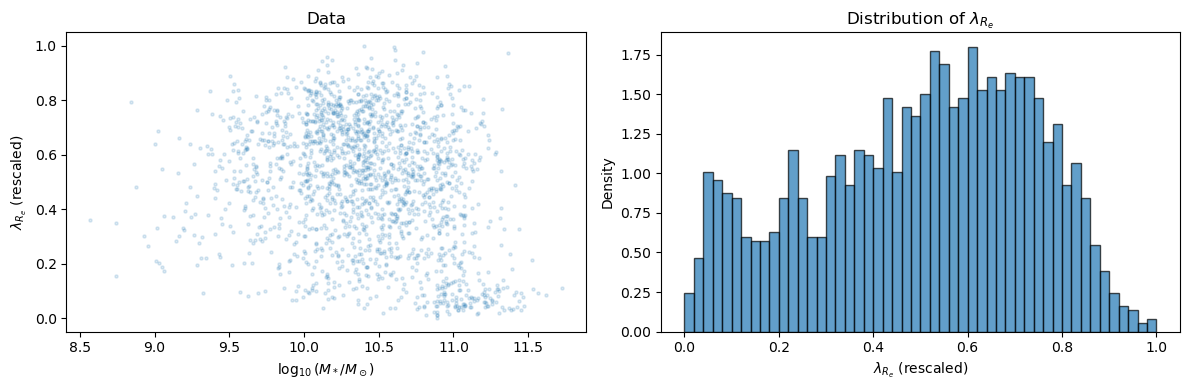

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(mass, y, alpha=0.15, s=5)
axes[0].set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
axes[0].set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
axes[0].set_title('Data')

axes[1].hist(y, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel(r'$\lambda_{R_e}$ (rescaled)')
axes[1].set_ylabel('Density')
axes[1].set_title(r'Distribution of $\lambda_{R_e}$')

plt.tight_layout()
plt.show()

## 2. Define Models

**Model 1**: Single beta distribution  
$$P(\lambda) = \text{Beta}(\lambda; \alpha, \beta)$$

**Model 2**: Two beta distributions, fixed mixture  
$$P(\lambda) = f \cdot \text{Beta}(\lambda; \alpha_\text{SR}, \beta_\text{SR}) + (1-f) \cdot \text{Beta}(\lambda; \alpha_\text{FR}, \beta_\text{FR})$$

**Model 3**: Two beta distributions, mass-dependent mixture  
$$P(\lambda | M) = f(M) \cdot \text{Beta}(\lambda; \alpha_\text{SR}, \beta_\text{SR}) + (1-f(M)) \cdot \text{Beta}(\lambda; \alpha_\text{FR}, \beta_\text{FR})$$
where $f(M) = \sigma(a \cdot (\log M - M_0))$

**Convention**: 
- SR = Slow Rotators (low $\lambda$, component 1)
- FR = Fast Rotators (high $\lambda$, component 2)
- $f$ = fraction of slow rotators
- We enforce mean(SR) < mean(FR) in the prior to break label-switching degeneracy

In [7]:
def sigmoid(x):
    """Numerically stable sigmoid."""
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))


def beta_mean(alpha, beta):
    """Mean of beta distribution."""
    return alpha / (alpha + beta)

### Model 1: Single Beta

In [9]:
def log_likelihood_M1(theta):
    """Single beta distribution."""
    alpha, beta = theta
    return np.sum(stats.beta.logpdf(y, alpha, beta))


def prior_transform_M1(u):
    """Uniform priors on alpha, beta in [0.5, 10]."""
    alpha = 0.5 + u[0] * 9.5
    beta = 0.5 + u[1] * 9.5
    return np.array([alpha, beta])

### Model 2: Two Betas, Fixed Mixture

In [11]:
def log_likelihood_M2(theta):
    """
    Two beta mixture, fixed fraction.
    theta = [alpha_SR, beta_SR, alpha_FR, beta_FR, f]
    f = fraction of slow rotators
    """
    alpha_SR, beta_SR, alpha_FR, beta_FR, f = theta
    
    pdf_SR = stats.beta.pdf(y, alpha_SR, beta_SR)
    pdf_FR = stats.beta.pdf(y, alpha_FR, beta_FR)
    
    mixture = f * pdf_SR + (1 - f) * pdf_FR
    mixture = np.maximum(mixture, 1e-300)
    
    return np.sum(np.log(mixture))


def prior_transform_M2(u):
    """
    Prior transform with ordering constraint.
    Enforces mean(SR) < mean(FR) to break label switching.
    """
    alpha1 = 0.5 + u[0] * 9.5
    beta1 = 0.5 + u[1] * 9.5
    alpha2 = 0.5 + u[2] * 9.5
    beta2 = 0.5 + u[3] * 9.5
    f = u[4]
    
    mean1 = beta_mean(alpha1, beta1)
    mean2 = beta_mean(alpha2, beta2)
    
    # Enforce: SR has lower mean, FR has higher mean
    if mean1 < mean2:
        alpha_SR, beta_SR = alpha1, beta1
        alpha_FR, beta_FR = alpha2, beta2
    else:
        alpha_SR, beta_SR = alpha2, beta2
        alpha_FR, beta_FR = alpha1, beta1
    
    return np.array([alpha_SR, beta_SR, alpha_FR, beta_FR, f])

### Model 3: Two Betas, Mass-Dependent Mixture

In [13]:
def log_likelihood_M3(theta):
    """
    Two beta mixture, mass-dependent fraction.
    theta = [alpha_SR, beta_SR, alpha_FR, beta_FR, a, M0]
    f(M) = sigmoid(a * (M - M0)) = fraction of slow rotators
    """
    alpha_SR, beta_SR, alpha_FR, beta_FR, a, M0 = theta
    
    f = sigmoid(a * (mass - M0))
    
    pdf_SR = stats.beta.pdf(y, alpha_SR, beta_SR)
    pdf_FR = stats.beta.pdf(y, alpha_FR, beta_FR)
    
    mixture = f * pdf_SR + (1 - f) * pdf_FR
    mixture = np.maximum(mixture, 1e-300)
    
    return np.sum(np.log(mixture))


def prior_transform_M3(u):
    """
    Prior transform with ordering constraint.
    a > 0 enforced so f increases with mass (more SR at high mass).
    """
    alpha1 = 0.5 + u[0] * 9.5
    beta1 = 0.5 + u[1] * 9.5
    alpha2 = 0.5 + u[2] * 9.5
    beta2 = 0.5 + u[3] * 9.5
    a = 0.1 + u[4] * 9.9      # Uniform(0.1, 10) - positive only
    M0 = 9.0 + u[5] * 3.0     # Uniform(9, 12)
    
    mean1 = beta_mean(alpha1, beta1)
    mean2 = beta_mean(alpha2, beta2)
    
    # Enforce: SR has lower mean, FR has higher mean
    if mean1 < mean2:
        alpha_SR, beta_SR = alpha1, beta1
        alpha_FR, beta_FR = alpha2, beta2
    else:
        alpha_SR, beta_SR = alpha2, beta2
        alpha_FR, beta_FR = alpha1, beta1
    
    return np.array([alpha_SR, beta_SR, alpha_FR, beta_FR, a, M0])

## 3. Run Nested Sampling

In [15]:
print("Running Model 1 (Single Beta)...")

sampler_M1 = dynesty.NestedSampler(
    log_likelihood_M1,
    prior_transform_M1,
    ndim=2,
    nlive=350,
    sample='rwalk'
)
sampler_M1.run_nested(print_progress=True)
results_M1 = sampler_M1.results

print(f"\nModel 1: log(Z) = {results_M1.logz[-1]:.2f} ± {results_M1.logzerr[-1]:.2f}")

Running Model 1 (Single Beta)...


3583it [00:18, 188.82it/s, +350 | bound: 7 | nc: 1 | ncall: 64201 | eff(%):  6.160 | loglstar:   -inf < 144.522 <    inf | logz: 135.455 +/-  0.152 | dlogz:  0.001 >  0.359]


Model 1: log(Z) = 135.46 ± 0.25


In [16]:
print("Running Model 2 (Two Betas, Fixed Mixture)...")

sampler_M2 = dynesty.NestedSampler(
    log_likelihood_M2,
    prior_transform_M2,
    ndim=5,
    nlive=350,
    sample='rwalk'
)
sampler_M2.run_nested(print_progress=True)
results_M2 = sampler_M2.results

print(f"\nModel 2: log(Z) = {results_M2.logz[-1]:.2f} ± {results_M2.logzerr[-1]:.2f}")

Running Model 2 (Two Betas, Fixed Mixture)...


5867it [01:25, 68.57it/s, +350 | bound: 14 | nc: 1 | ncall: 128654 | eff(%):  4.846 | loglstar:   -inf < 219.200 <    inf | logz: 203.498 +/-  0.207 | dlogz:  0.001 >  0.359]


Model 2: log(Z) = 203.50 ± 0.31


In [ ]:
print("Running Model 3 (Two Betas, Mass-Dependent)...")

sampler_M3 = dynesty.NestedSampler(
    log_likelihood_M3,
    prior_transform_M3,
    ndim=6,
    nlive=350,
    sample='rwalk'
)
sampler_M3.run_nested(print_progress=True)
results_M3 = sampler_M3.results

print(f"\nModel 3: log(Z) = {results_M3.logz[-1]:.2f} ± {results_M3.logzerr[-1]:.2f}")

Running Model 3 (Two Betas, Mass-Dependent)...


1131it [00:06, 66.09it/s, bound: 0 | nc: 8 | ncall: 8834 | eff(%): 12.803 | loglstar:   -inf < -24.485 <    inf | logz: -32.484 +/-  0.142 | dlogz: 327.747 >  0.359]     

## 4. Model Comparison

In [ ]:
logZ_M1 = results_M1.logz[-1]
logZ_M2 = results_M2.logz[-1]
logZ_M3 = results_M3.logz[-1]

logZ_err_M1 = results_M1.logzerr[-1]
logZ_err_M2 = results_M2.logzerr[-1]
logZ_err_M3 = results_M3.logzerr[-1]

print("=" * 55)
print("LOG-EVIDENCES")
print("=" * 55)
print(f"Model 1 (Single Beta):        log(Z) = {logZ_M1:8.2f} ± {logZ_err_M1:.2f}")
print(f"Model 2 (Two Betas, fixed f): log(Z) = {logZ_M2:8.2f} ± {logZ_err_M2:.2f}")
print(f"Model 3 (Two Betas, f(M)):    log(Z) = {logZ_M3:8.2f} ± {logZ_err_M3:.2f}")

In [ ]:
log_BF_21 = logZ_M2 - logZ_M1
log_BF_31 = logZ_M3 - logZ_M1
log_BF_32 = logZ_M3 - logZ_M2

print("\n" + "=" * 55)
print("BAYES FACTORS")
print("=" * 55)
print(f"B_21 (Model 2 vs Model 1): 10^{log_BF_21/np.log(10):.1f}  [Δlog(Z) = {log_BF_21:.1f}]")
print(f"B_31 (Model 3 vs Model 1): 10^{log_BF_31/np.log(10):.1f}  [Δlog(Z) = {log_BF_31:.1f}]")
print(f"B_32 (Model 3 vs Model 2): 10^{log_BF_32/np.log(10):.1f}  [Δlog(Z) = {log_BF_32:.1f}]")

In [ ]:
# Model probabilities (assuming equal prior odds)
log_Zs = np.array([logZ_M1, logZ_M2, logZ_M3])
log_Z_max = np.max(log_Zs)
log_Z_total = log_Z_max + np.log(np.sum(np.exp(log_Zs - log_Z_max)))

P_M1 = np.exp(logZ_M1 - log_Z_total)
P_M2 = np.exp(logZ_M2 - log_Z_total)
P_M3 = np.exp(logZ_M3 - log_Z_total)

print("\n" + "=" * 55)
print("MODEL PROBABILITIES (equal prior odds)")
print("=" * 55)
print(f"P(Model 1 | Data) = {P_M1:.2e}")
print(f"P(Model 2 | Data) = {P_M2:.2e}")
print(f"P(Model 3 | Data) = {P_M3:.2e}")

## 5. Best-Fit Parameters

In [ ]:
# Get weighted mean parameters for each model
weights_M1 = np.exp(results_M1.logwt - results_M1.logz[-1])
weights_M2 = np.exp(results_M2.logwt - results_M2.logz[-1])
weights_M3 = np.exp(results_M3.logwt - results_M3.logz[-1])

params_M1 = np.average(results_M1.samples, weights=weights_M1, axis=0)
params_M2 = np.average(results_M2.samples, weights=weights_M2, axis=0)
params_M3 = np.average(results_M3.samples, weights=weights_M3, axis=0)

print("Model 1 parameters:")
print(f"  α = {params_M1[0]:.2f}, β = {params_M1[1]:.2f}")
print(f"  mean = {beta_mean(params_M1[0], params_M1[1]):.3f}")

print("\nModel 2 parameters:")
print(f"  Slow rotators: α_SR = {params_M2[0]:.2f}, β_SR = {params_M2[1]:.2f}, mean = {beta_mean(params_M2[0], params_M2[1]):.3f}")
print(f"  Fast rotators: α_FR = {params_M2[2]:.2f}, β_FR = {params_M2[3]:.2f}, mean = {beta_mean(params_M2[2], params_M2[3]):.3f}")
print(f"  f (SR fraction) = {params_M2[4]:.3f}")

print("\nModel 3 parameters:")
print(f"  Slow rotators: α_SR = {params_M3[0]:.2f}, β_SR = {params_M3[1]:.2f}, mean = {beta_mean(params_M3[0], params_M3[1]):.3f}")
print(f"  Fast rotators: α_FR = {params_M3[2]:.2f}, β_FR = {params_M3[3]:.2f}, mean = {beta_mean(params_M3[2], params_M3[3]):.3f}")
print(f"  a = {params_M3[4]:.2f}")
print(f"  M_0 = {params_M3[5]:.2f} (mass where f = 0.5)")

In [ ]:
# Corner plot for Model 3
labels_M3 = [r'$\alpha_{SR}$', r'$\beta_{SR}$', r'$\alpha_{FR}$', r'$\beta_{FR}$', r'$a$', r'$M_0$']

fig, axes = dyplot.cornerplot(
    results_M3,
    labels=labels_M3,
    show_titles=True,
    title_kwargs={'fontsize': 11}
)
plt.suptitle('Model 3 Posterior', y=1.02, fontsize=14)
plt.show()

## 6. Visualise Model Fits

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Grid for PDF evaluation
mass_grid = np.linspace(mass.min(), mass.max(), 100)
lambda_grid = np.linspace(0.001, 0.999, 100)
M_mesh, L_mesh = np.meshgrid(mass_grid, lambda_grid)

# ============ Model 1 ============
ax = axes[0]
alpha, beta = params_M1
pdf_M1 = stats.beta.pdf(L_mesh, alpha, beta)

ax.scatter(mass, y, alpha=0.15, s=3, c='grey', zorder=1)
ax.contourf(M_mesh, L_mesh, pdf_M1, levels=15, cmap='Blues', alpha=0.7, zorder=0)
ax.contour(M_mesh, L_mesh, pdf_M1, levels=5, colors='blue', linewidths=0.5, zorder=2)

ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 1: Single Beta\nlog Z = {logZ_M1:.1f}')

# ============ Model 2 ============
ax = axes[1]
alpha_SR, beta_SR, alpha_FR, beta_FR, f = params_M2
pdf_SR = stats.beta.pdf(L_mesh, alpha_SR, beta_SR)
pdf_FR = stats.beta.pdf(L_mesh, alpha_FR, beta_FR)

ax.scatter(mass, y, alpha=0.15, s=3, c='grey', zorder=1)
ax.contourf(M_mesh, L_mesh, f * pdf_SR, levels=15, cmap='Reds', alpha=0.6, zorder=0)
ax.contourf(M_mesh, L_mesh, (1-f) * pdf_FR, levels=15, cmap='Blues', alpha=0.6, zorder=0)
ax.contour(M_mesh, L_mesh, f * pdf_SR, levels=4, colors='red', linewidths=0.5, zorder=2)
ax.contour(M_mesh, L_mesh, (1-f) * pdf_FR, levels=4, colors='blue', linewidths=0.5, zorder=2)

ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 2: Two Betas, f = {f:.2f}\nlog Z = {logZ_M2:.1f}')

# ============ Model 3 ============
ax = axes[2]
alpha_SR, beta_SR, alpha_FR, beta_FR, a, M0 = params_M3
pdf_SR = stats.beta.pdf(L_mesh, alpha_SR, beta_SR)
pdf_FR = stats.beta.pdf(L_mesh, alpha_FR, beta_FR)
f_M = sigmoid(a * (M_mesh - M0))  # Mass-dependent fraction

ax.scatter(mass, y, alpha=0.15, s=3, c='grey', zorder=1)
ax.contourf(M_mesh, L_mesh, f_M * pdf_SR, levels=15, cmap='Reds', alpha=0.6, zorder=0)
ax.contourf(M_mesh, L_mesh, (1-f_M) * pdf_FR, levels=15, cmap='Blues', alpha=0.6, zorder=0)
ax.contour(M_mesh, L_mesh, f_M * pdf_SR, levels=4, colors='red', linewidths=0.5, zorder=2)
ax.contour(M_mesh, L_mesh, (1-f_M) * pdf_FR, levels=4, colors='blue', linewidths=0.5, zorder=2)
ax.axvline(M0, ls='--', c='black', lw=2, label=f'$M_0$ = {M0:.2f}')
ax.legend(loc='upper left')

ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$')
ax.set_ylabel(r'$\lambda_{R_e}$ (rescaled)')
ax.set_title(f'Model 3: Two Betas, f(M)\nlog Z = {logZ_M3:.1f}')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.6, label='Slow Rotators'),
                   Patch(facecolor='blue', alpha=0.6, label='Fast Rotators')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.show()

In [ ]:
# Plot the mass-dependent slow rotator fraction for Model 3
fig, ax = plt.subplots(figsize=(8, 5))

mass_plot = np.linspace(8.5, 12, 200)
alpha_SR, beta_SR, alpha_FR, beta_FR, a, M0 = params_M3
f_plot = sigmoid(a * (mass_plot - M0))

ax.plot(mass_plot, f_plot, 'k-', lw=2)
ax.axhline(0.5, ls=':', c='grey', alpha=0.7)
ax.axvline(M0, ls='--', c='red', alpha=0.7, label=f'$M_0$ = {M0:.2f}')

ax.fill_between(mass_plot, 0, f_plot, alpha=0.3, color='red', label='Slow Rotators')
ax.fill_between(mass_plot, f_plot, 1, alpha=0.3, color='blue', label='Fast Rotators')

ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=12)
ax.set_ylabel('Fraction', fontsize=12)
ax.set_title('Model 3: Slow Rotator Fraction vs Stellar Mass', fontsize=14)
ax.set_xlim(8.5, 12)
ax.set_ylim(0, 1)
ax.legend(loc='center right')

plt.tight_layout()
plt.show()

In [ ]:
# 1D histogram comparison
fig, ax = plt.subplots(figsize=(8, 5))

lambda_plot = np.linspace(0.001, 0.999, 200)

# Data histogram
ax.hist(y, bins=40, density=True, alpha=0.4, color='grey', edgecolor='black', label='Data')

# Model 1
pdf1 = stats.beta.pdf(lambda_plot, params_M1[0], params_M1[1])
ax.plot(lambda_plot, pdf1, 'g-', lw=2, label='Model 1')

# Model 2
alpha_SR, beta_SR, alpha_FR, beta_FR, f = params_M2
pdf2 = f * stats.beta.pdf(lambda_plot, alpha_SR, beta_SR) + \
       (1-f) * stats.beta.pdf(lambda_plot, alpha_FR, beta_FR)
ax.plot(lambda_plot, pdf2, 'b--', lw=2, label='Model 2')

# Model 3 (averaged over mass distribution)
alpha_SR, beta_SR, alpha_FR, beta_FR, a, M0 = params_M3
pdf3 = np.zeros_like(lambda_plot)
for m in mass:
    f_m = sigmoid(a * (m - M0))
    pdf3 += f_m * stats.beta.pdf(lambda_plot, alpha_SR, beta_SR) + \
            (1-f_m) * stats.beta.pdf(lambda_plot, alpha_FR, beta_FR)
pdf3 /= len(mass)
ax.plot(lambda_plot, pdf3, 'r-', lw=2, label='Model 3')

ax.set_xlabel(r'$\lambda_{R_e}$ (rescaled)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Model Comparison: Marginal Distribution', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

## 7. Summary

**Findings:**
- Model 3 (mass-dependent mixture) is decisively favoured
- The slow rotator fraction increases with stellar mass
- The transition occurs around $M_0 \approx$ 10.5–11 (in log solar masses)

**Bayesian model comparison directly answers**: "Which model best explains the data?" — not just "can we reject a null hypothesis?"